# Imports

In [20]:
import numpy as np
import serial
from PIL import Image
import matplotlib.pyplot as plt
import time

# Load Image

In [54]:
image_path = 'original.png'

image = Image.open(image_path).convert('L')
image_array = np.array(image)
print('Image array shape:', image_array.shape)

height = image_array.shape[0]
width = image_array.shape[1]
print("shape: ", image_array.shape)
print("height: ", height)
print("width: ", width)

Image array shape: (480, 640)
shape:  (480, 640)
height:  480
width:  640


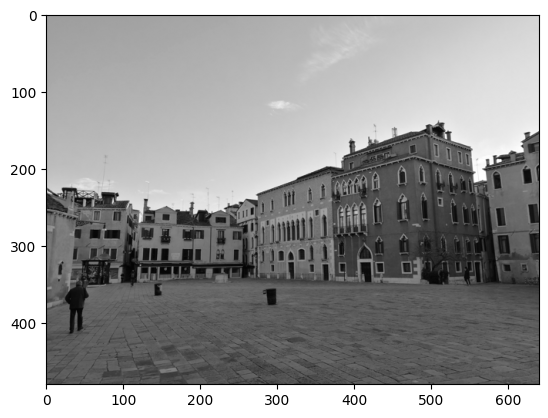

In [3]:
plt.imshow(image_array, cmap='gray')
plt.show()

# Creating testbench golden files

### Create golden_input.txt from img_array

In [6]:
! mkdir testbench

In [11]:
input_file = "./testbench/golden_input.txt"
output_file = "./testbench/golden_output.txt"
out_png = "./testbench/golden_output.png"

with open(input_file, "w") as f:
    for i in range(height-2):
        for j in range(width):
            for k in range(3):
                f.writelines(f"{hex(image_array[i+k][j])[2:].upper()}\n")

with open(input_file, "r", encoding="utf-8") as f:
    content = f.read()

# Remove last character
content = content[:-1]

with open(input_file, "w", encoding="utf-8") as f:
    f.write(content)

### Image sharpenining filter implementation

In [12]:
# The same code will be implemented with C++ in HLS
SharpeningCoeffs = [
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
]

# Shift register
data_in_array = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]

def ImgSharpeningFilter(data_in_0, data_in_1, data_in_2):
    global data_in_array

    for i in range(3):
        for j in range(2, 0, -1):
            data_in_array[i][j] = data_in_array[i][j - 1]

    data_in_array[0][0] = int(data_in_0)
    data_in_array[1][0] = int(data_in_1)
    data_in_array[2][0] = int(data_in_2)

    add_res = 0
    for i in range(3):
        for j in range(3):
            add_res += data_in_array[i][j] * SharpeningCoeffs[i][j]

    # Clamp to 8-bit range
    if add_res < 0:
        add_res = 0
    elif add_res > 255:
        add_res = 255

    return add_res


### From golden_input.txt generate golden_output.txt with the ImgSharpeningFilter

In [13]:
# Remember to restart the shift register
with open(input_file, "r") as fin, open(output_file, "w") as fout:
    lines = fin.readlines()

    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):
            break

        b0 = int(lines[i].strip(), 16)
        b1 = int(lines[i + 1].strip(), 16)
        b2 = int(lines[i + 2].strip(), 16)

        result = ImgSharpeningFilter(b0, b1, b2)

        fout.write(f"{result:02X}\n")

### Test the golden_output.txt

Saved ./testbench/golden_output.png (478x640)


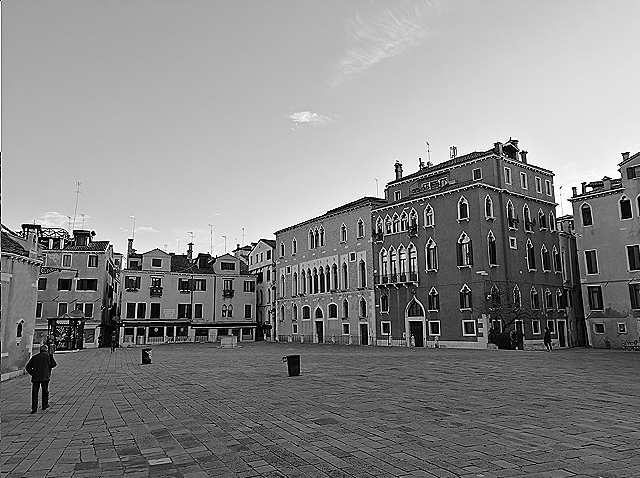

In [15]:
# Read hex bytes (one per line)
with open(output_file, "r") as f:
    vals = [int(line.strip(), 16) for line in f if line.strip()]

expected = (height-2) * width
if len(vals) < expected:
    raise ValueError(f"Not enough pixels: got {len(vals)}, expected {expected}")
if len(vals) > expected:
    vals = vals[:expected]  # ignore extras

# Reshape into image (row-major: first 640 lines = first row)
img = np.array(vals, dtype=np.uint8).reshape(((height-2), width))

# Save / display
Image.fromarray(img, mode="L").save(out_png)
print(f"Saved {out_png} ({(height-2)}x{width})")

pil_img = Image.fromarray(img, mode="L")
display(pil_img)


# Running FPGA

### Serial configuratation

In [24]:
! mkdir output

In [76]:
run_path = 'lenna.png'
output_name = 'lenna_sharp'
output_bin = f"./output/{output_name}.bin"
output_png = f"./output/{output_name}.png"
array = np.array(Image.open(run_path).convert('L'))
Image.fromarray(array, mode="L").save(run_path)
height = array.shape[0]
width = array.shape[1]
raw_bytes = array.tobytes()


print("shape: ", array.shape)
print("height: ", height)
print("width: ", width)
print("len(raw_bytes): ", len(raw_bytes)/(1024*1024), "MB")

shape:  (512, 512)
height:  512
width:  512
len(raw_bytes):  0.25 MB


In [72]:
port = "/dev/ttyUSB2" 
baudrate = 921600
nbytes = (height-2) * width
ser = serial.Serial(port, 921600, timeout=1)

if ser.is_open:
    print(f"--- Connected to {port} at {baudrate} baud ---")

--- Connected to /dev/ttyUSB2 at 921600 baud ---


### Send height and width, wait for READY

In [73]:
data = f"{{height:{height},width:{width}}}"
ser.write(data.encode('utf-8'))
rx = ser.read(6)
print(rx)

b'READY'


### Send image and recive filtered data

In [74]:
data = bytearray()
t0 = time.time()

ser.write(raw_bytes)

while len(data) < nbytes:
    chunk = ser.read(nbytes - len(data))
    if chunk:
        data += chunk
    else:
        # no data arrived during this timeout window
        if time.time() - t0 > 20:   # hard limit, adjust as needed
            break

if len(data) != nbytes:
    raise RuntimeError(f"Expected {nbytes} bytes, got {len(data)}")

with open(output_bin, "wb") as f:
    f.write(data)

print(f"Saved {len(data)} bytes to {output_bin}")
ser.close()


Saved 261120 bytes to ./output/lenna_sharp.bin


# Recreate image

Saved recreated image to ./output/lenna_sharp.png


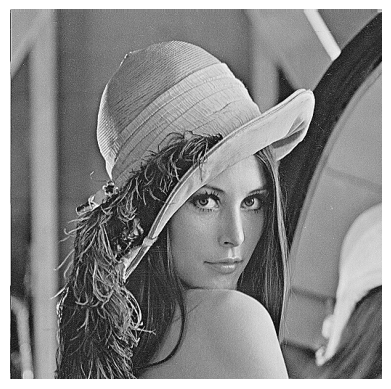

In [75]:
img = np.fromfile(output_bin, dtype=np.uint8)
if img.size != (height-2) * width:
    raise ValueError(f"Expected {(height-2) * width} bytes, got {img.size}")

img = img.reshape((height-2, width))

Image.fromarray(img, mode="L").save(output_png)
print(f"Saved recreated image to {output_png}")

plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()